## Dependencies

In [1]:
#Import functions and libraries. Install if not prev. installed on kernel.
j=0
while j<=1:
  try:
    import pandas as pd
    import numpy as np
    from scipy.stats import ttest_ind
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from stargazer.stargazer import Stargazer
    from rdd import rdd
    j=2
  except Exception as e:
    !pip install stargazer
    !pip install rdd
    !pip install statsmodels
    j+=1

In [2]:
## We do not care about setting values on slices of dataframe, so supress warning messages about this:
pd.options.mode.chained_assignment = None

## Data import

In [3]:
#Read data - two data sets are merged. The data sets are constructed 24 hours apart.
#Read 28-03-2021 data
df_t = pd.read_csv('data_elgiganten_28032021.csv')
#Read 29-03-2021 data
df_t_minus_1 = pd.read_csv('data_elgiganten_29032021.csv')
#Merge data
df = pd.merge(df_t, df_t_minus_1, left_on = 'sku',right_on = 'sku',suffixes = ("_t","_t-1")) 

C:\Users\espen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (26,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data manipulation (not altering the data set in any comprimising way)

- $Y_i = $ dummy indicating wether a product has been purchased or not `['purchase_dummy']` in dataset. 
- $x_i = $ inventory distance to closest cutoff at beginning of 24 hour period. `['closest_cutoff_distance']` in dataset.   
- $D(x_i) = $ Dummy. 1 if inventory greater than closest cutoff for product _i_ else 0.  It is the relevant treatment variable in our study. `['treatment_dummy_t-1']` in dataset.

We have a big limitation - only measured clicks and purchases at one time. If a product is purchased then intuitively inventory is lowered by one. If the product crosses the cutoff from day to day then the product is discarded to avoid this problem. This might create a (huge) selection bias. The issue arises due to the nature of the (aggregated) data - we do not have data on each purchase or click but only how many units of a given products that have been sold (and clicked upon). 

#### Outcome variable

In [4]:
##Outcome variable - has product been purchased during the last 24 hours.df['purchase_daily_t'] > 0:
df.loc[df['purchase_daily_t'] > 0,'purchase_dummy_t'] = 1
df.loc[df['purchase_daily_t'] == 0,'purchase_dummy_t'] = 0
unique_purchase_count = sum(df['purchase_dummy_t'])
unique_purchase_share = round(df['purchase_dummy_t'].mean()*100,1)
print(f'Number of unique skus purchased: {unique_purchase_count}, which corresponds to {unique_purchase_share} pct. of total SKUs')


Number of unique skus purchased: 1246.0, which corresponds to 8.8 pct. of total SKUs


#### Running variable in a Regression Discontinuity Design

In [5]:
##Running variable

#define function to find closest cutoff for a given inventory measure
def assign_to_closest_cutoff(df,input_name,cutoff_min, cutoff_max, cutoff_values):
    cutoff_criteria = [df[input_name].between(cutoff_min[i],cutoff_max[i]) for i in range(0,len(cutoff_min))] 
    return np.select(cutoff_criteria,cutoff_values,0)

#Define closest cutoff intervals
cutoff_min = [0,0,14.5,37.5,74.5]
cutoff_max = [0,14.5,37.5,74.5,max(df['inventory_t-1'])]
cutoff_value = [0,4.5,24.5,49.5,99.5]

#Store closest cutoff in df
df['closest_cutoff_t-1'] = assign_to_closest_cutoff(df, 'inventory_t-1', cutoff_min, cutoff_max, cutoff_value)

#Distance to closest cutoff is running variable.
df['closest_cutoff_distance_t-1'] = df['inventory_t-1'] - df['closest_cutoff_t-1'] 

#### Treatment variable (greater than zero running variable)

In [6]:
##Treatment variable

df.rename({'stock_lvl_ecom_format_t':'treatment_string_t'},axis=1,inplace=True)
df.rename({'stock_lvl_ecom_format_t-1':'treatment_string_t-1'},axis=1,inplace=True)
#Create indicator variable of above, equal or below cutoff. 
#By definition of the cutoffs "equal to cutoff" will contain zero true elements but those with zero inventory
df.loc[df['closest_cutoff_distance_t-1'] < 0,'cutoff_prefix'] = 'below_cutoff_t-1'
df.loc[df['closest_cutoff_distance_t-1'] > 0,'cutoff_prefix'] = 'above_cutoff_t-1'
df.loc[df['closest_cutoff_distance_t-1'] == 0,'cutoff_prefix'] = 'zero_inventory_t-1'
df=pd.concat([df,pd.get_dummies(df.loc[:,'cutoff_prefix'])],1) 

#copy "above cutoff" to construct treatment dummy.
df.loc[:,'treatment_dummy_t-1'] = df.loc[:,'above_cutoff_t-1']

#### Predetermined variables

In [7]:
## Rename and manipulate some predetermined covariates
#rating, set average rating of products with no rating to be not avalaible.
df.rename({'bazaarvoice_average_rating_percent_t-1':'average_rating_pct_t-1'},axis=1,inplace=True)
df.loc[df['total_rating_count_t-1']==0,['average_rating_pct_t-1']] = np.NaN
#campaign to integer dummy from boolean True/False formating
df['IsOnCampaign_t-1'] = df['IsOnCampaign_t-1'].astype(int)

## Data analysis

#### Removing observations

In [8]:
print(f'observation count in original dataset: {len(df)}')

#Only look at products that have been clicked at and where inventory is available
df_cleaned = df.loc[df['inventory_t-1'].notna(),:]
count_wo_invNA=len(df_cleaned)
print(f'observations removed due to inventory data being N/A: {len(df)-count_wo_invNA}')

observation count in original dataset: 14130
observations removed due to inventory data being N/A: 3476


#### Removing products with zero inventory 

In [9]:
df_cleaned_no_zero_inventory = df_cleaned.loc[df_cleaned['zero_inventory_t-1']!=1,:]

#### Describe remaining data (table)

In [10]:
# df_cleaned_no_zero_inventory[:,['closest_cutoff_distance_t-1',
#                     'purchase_dummy_t',
#                     'price_t-1',
#                     'view_daily_t-1',
#                     'purchase_daily_t-1',
#                     'total_rating_count_t-1',
#                     'average_rating_pct_t-1',
#                     'IsOnCampaign_t-1']].describe()

#### Comparison of means across cutoffs

##### Table

In [11]:
df_mean_not_pooled = df_cleaned.groupby(['closest_cutoff_t-1','cutoff_prefix']) \
        .agg({'sku':'size',
              'inventory_t-1':['mean',np.std],
              'price_t-1':['mean',np.std,],
              'view_daily_t':['mean',np.std],
              'purchase_dummy_t':['mean',np.std],
              'total_rating_count_t-1':['mean',np.std],
              'average_rating_pct_t-1':['mean',np.std],
              'IsOnCampaign_t-1':['mean',np.std]
             }) \
        .sort_values(['closest_cutoff_t-1','cutoff_prefix'],ascending=[True,False])

df_mean_pooled = df_cleaned.groupby('cutoff_prefix') \
        .agg({'sku':'size',
              'inventory_t-1':['mean',np.std],
              'price_t-1':['mean',np.std,],
              'view_daily_t':['mean',np.std],
              'purchase_dummy_t':['mean',np.std],
              'total_rating_count_t-1':['mean',np.std],
              'average_rating_pct_t-1':['mean',np.std],
              'IsOnCampaign_t-1':['mean',np.std]
             }) \
        .sort_values(['cutoff_prefix'],ascending=[False])

tuples = [('pooled','zero inventory'),('pooled','below cutoff'),('pooled','above cutoff')]
index = pd.MultiIndex.from_tuples(tuples, names=['closest_cutoff_t-1','cutoff_prefix'])
df_mean_pooled.index = index

In [12]:
df_mean = df_mean_not_pooled
df_mean = df_mean.append(df_mean_pooled)

In [13]:
variables_of_interest = ['inventory_t-1', 
                         'view_daily_t',
                         'purchase_dummy_t',
                         'price_t-1',
                         'total_rating_count_t-1',
                         'average_rating_pct_t-1',
                         'IsOnCampaign_t-1']

cutoff_values = cutoff_value.copy()
cutoff_values.append('pooled')
cutoff_values.pop(0)

for variable in variables_of_interest:
    for cutoff in cutoff_values:
        if not isinstance(cutoff, str):
            series_above = df_cleaned.loc[(df_cleaned['closest_cutoff_t-1']==cutoff) & (df_cleaned['cutoff_prefix']=='above_cutoff_t-1'),variable] 
            series_below = df_cleaned.loc[(df_cleaned['closest_cutoff_t-1']==cutoff) & (df_cleaned['cutoff_prefix']=='below_cutoff_t-1'),variable] 
        else:
            series_above = df_cleaned.loc[(df_cleaned['cutoff_prefix']=='above_cutoff_t-1'),variable] 
            series_below = df_cleaned.loc[(df_cleaned['cutoff_prefix']=='below_cutoff_t-1'),variable] 
        ttest = ttest_ind(series_above,series_below,nan_policy ='omit',equal_var=False)
        df_mean.loc[(cutoff,'diff'),(variable,'mean')] = np.mean(series_above) -np.mean(series_below)
        df_mean.loc[(cutoff,'diff'),(variable,'std')] = ttest[1]

comparison_of_means_table = df_mean.sort_index().transpose()

In [14]:
comparison_of_means_table

closest_cutoff_t-1                         0.0              4.5  \
cutoff_prefix               zero_inventory_t-1 above_cutoff_t-1   
sku                    size        4034.000000       913.000000   
inventory_t-1          mean           0.000000         8.529025   
                       std            0.000000         2.801449   
price_t-1              mean        4665.424874      2747.867196   
                       std         5789.272702      4598.926600   
view_daily_t           mean          13.131879         5.032859   
                       std           49.507547        15.883865   
purchase_dummy_t       mean           0.076599         0.042716   
                       std            0.265987         0.202328   
total_rating_count_t-1 mean          13.704268         5.098343   
                       std           66.766500        28.732522   
average_rating_pct_t-1 mean          82.737200        81.726891   
                       std           17.944545        21.405395   
IsOnCampaign_t-1       mean           0.267724         0.083242   
                       std            0.442828         0.276399   

closest_cutoff_t-1                                                    24.5  \
cutoff_prefix               below_cutoff_t-1         diff above_cutoff_t-1   
sku                    size       687.000000          NaN       483.000000   
inventory_t-1          mean         2.407569     6.121456        30.051760   
                       std          1.116978     0.000000         3.699194   
price_t-1              mean      4002.106477 -1254.239281      2500.401553   
                       std       6748.177888     0.000030      4216.024771   
view_daily_t           mean         4.655022     0.377837         9.925466   
                       std         16.240864     0.642010        25.962921   
purchase_dummy_t       mean         0.029112     0.013604         0.080745   
                       std          0.168243     0.142671         0.272726   
total_rating_count_t-1 mean         3.124269     1.974074         8.533333   
                       std         19.569916     0.103936        33.776605   
average_rating_pct_t-1 mean        82.159420    -0.432530        83.891304   
                       std         20.280963     0.845304        17.531210   
IsOnCampaign_t-1       mean         0.101892    -0.018650         0.142857   
                       std          0.302727     0.205778         0.350290   

closest_cutoff_t-1                                                      49.5  \
cutoff_prefix               below_cutoff_t-1           diff above_cutoff_t-1   
sku                    size       563.000000            NaN       478.000000   
inventory_t-1          mean        19.060391   1.099137e+01        61.092050   
                       std          2.573457  3.067810e-280         6.973137   
price_t-1              mean      2417.491385   8.291017e+01      2317.959833   
                       std       4084.736435   7.477736e-01      3662.198438   
view_daily_t           mean         7.925400   2.000066e+00        18.742678   
                       std         21.908288   1.825462e-01        79.275326   
purchase_dummy_t       mean         0.069272   1.147358e-02         0.140167   
                       std          0.254142   4.841369e-01         0.347524   
total_rating_count_t-1 mean         7.026690   1.506643e+00        10.964361   
                       std         57.093172   5.983975e-01        48.504405   
average_rating_pct_t-1 mean        79.094737   4.796568e+00        84.913242   
                       std         22.355745   2.129625e-02        16.075417   
IsOnCampaign_t-1       mean         0.095915   4.694240e-02         0.156904   
                       std          0.294736   2.038910e-02         0.364091   

closest_cutoff_t-1                                                      99.5  \
cutoff_prefix               below_cutoff_t-1           diff above_cutoff_t-1   
sku         

##### Comparison of means (estimation of baseline model without restricting data on bandwidth)

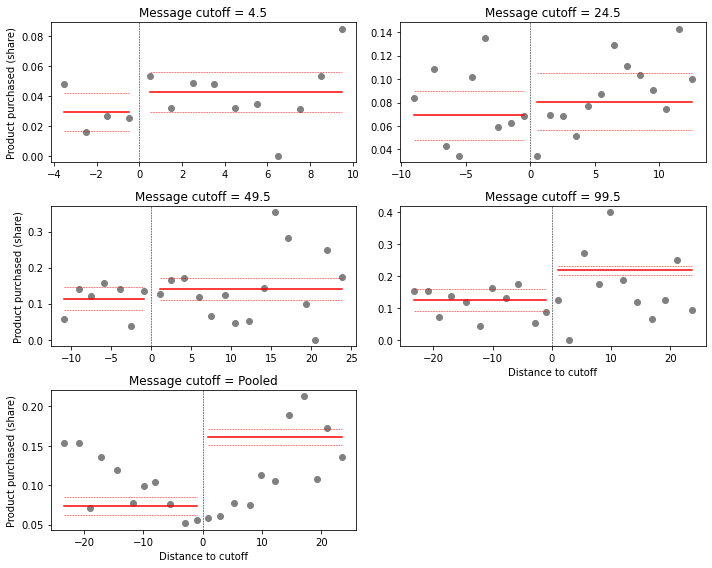

In [15]:
fig, axs = plt.subplots(3,2,figsize=(10,8))
cutoffs = [4.5,24.5,49.5,99.5,"Pooled"]

for x,k in enumerate(cutoffs):
  if k != "Pooled":
    #Data for Regression  
    df_reg_k = df_cleaned_no_zero_inventory.loc[df_cleaned_no_zero_inventory['closest_cutoff_t-1']==k,:] 
  else:
    #Data for Regression  
    df_reg_k = df_cleaned_no_zero_inventory
  
  #Regression
  treatment = df_reg_k['treatment_dummy_t-1']
  res = ols('purchase_dummy_t ~ treatment', df_reg_k).fit(cov_type='HC0')

  #Fitted values to df
  df_reg_k['predictions'] = res.fittedvalues
  #upper ci to df
  df_reg_k['predictions_ci_u'] = res.get_prediction().summary_frame(alpha=0.05)['mean_ci_upper']
  #lower ci to df
  df_reg_k['predictions_ci_l'] = res.get_prediction().summary_frame(alpha=0.05)['mean_ci_lower']
  
  #Drop running variable greater than 125 for visualisation purposes
  df_rd_graph_k = df_reg_k.loc[df_reg_k['inventory_t-1']<125,:]
  
  #Bin variables
  df_rd_graph_k[f'closest_cutoff_distance_binned'] = pd.cut(x=df_rd_graph_k['closest_cutoff_distance_t-1'], bins=22)
  df_binned = df_rd_graph_k.groupby('closest_cutoff_distance_binned').mean()
  
  #plot
  plt.subplot(3,2,x+1)
  plt.scatter(df_binned['closest_cutoff_distance_t-1'],df_binned['purchase_dummy_t'],marker='o', color = 'grey')
  plt.axvline(x=0, ls = '--', lw = 0.5,color = 'black')
  
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions'],marker='', color ='red')
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions'],marker='', color ='red')
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions_ci_u'],marker='', color ='red', lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions_ci_u'],marker='', color ='red' , lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions_ci_l'],marker='', color ='red', lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions_ci_l'],marker='', color ='red', lw = 0.5, ls = "--")


  plt.title(f'Message cutoff = {k}')
  if x == 3 or x == 4:
    plt.xlabel('Distance to cutoff')
  if  x == 0 or x == 2 or x == 4:
    plt.ylabel('Product purchased (share)')


axs[2][1].set_visible(False)
fig.tight_layout()
plt.show()

#### Non-parametric estimation of basline model


Non-parametric estimation: $Y_i = \alpha + D_{i}(x_i)$  
Relies solely on algorithm to decide the RDD bandwidth.

In [16]:
model_no_linear_trend = []
optimal_bandwidths = []
cutoffs = [4.5,24.5,49.5,99.5,'Pooled']

for cutoff in cutoffs:
  if cutoff != "Pooled":
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory.loc[df_cleaned_no_zero_inventory['closest_cutoff_t-1']==cutoff,:]
  else:
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory
    
  #Find optimal BW
  optimal_b = rdd.optimal_bandwidth(df_rdd['purchase_dummy_t'],df_rdd['closest_cutoff_distance_t-1']) 
 
  #store optimal bw
  optimal_bandwidths.append(optimal_b)

  df_k = df_rdd.loc[abs(df_rdd.loc[:,'closest_cutoff_distance_t-1']) < optimal_b,:]
  model_no_linear_trend.append(sm.OLS(df_k['purchase_dummy_t'],sm.add_constant(df_k.loc[:,'treatment_dummy_t-1'])).fit(cov_type='HC0'))

stargazer = Stargazer(model_no_linear_trend)
stargazer.custom_columns([f'cutoff = {cutoffs[0]}\n bw = {round(optimal_bandwidths[0],1)}',
                          f'cutoff = {cutoffs[1]}\n bw = {round(optimal_bandwidths[1],1)}',
                          f'cutoff = {cutoffs[2]}\n bw = {round(optimal_bandwidths[2],1)}',
                          f'cutoff = {cutoffs[3]}\n bw = {round(optimal_bandwidths[3],1)}',
                          f'cutoffs are Pooled\n bw = {round(optimal_bandwidths[4],1)}'],
                         [1 for x in model_no_linear_trend])
stargazer

### Regression discontinuity pooled treatment (different bws)

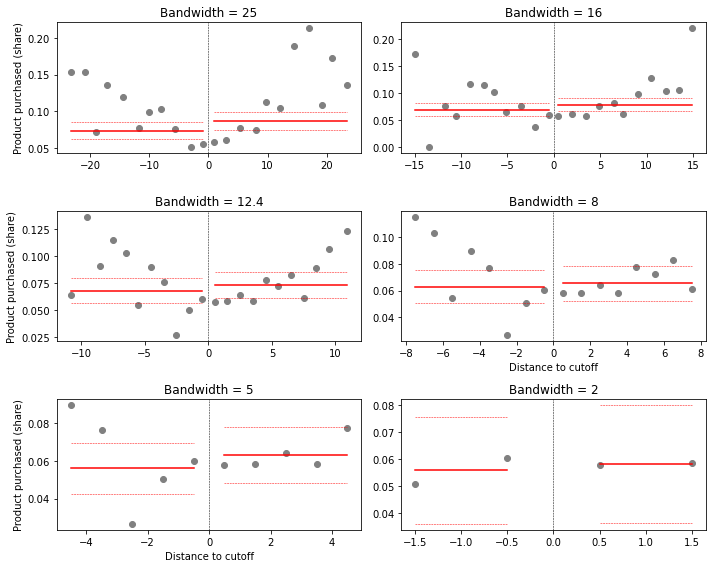

In [17]:
fig, axs = plt.subplots(3,2,figsize=(10,8))
#Find optimal BW
optimal_b = rdd.optimal_bandwidth(df_rdd['purchase_dummy_t'],df_rdd['closest_cutoff_distance_t-1']) 

bws = [25,16,optimal_b,8,5,2]

for x,k in enumerate(bws):
  df_reg_k = df_cleaned_no_zero_inventory.loc[abs(df_cleaned_no_zero_inventory['closest_cutoff_distance_t-1']) < k] 
  
  #Regression
  treatment = df_reg_k['treatment_dummy_t-1']
  res = ols('purchase_dummy_t ~ treatment', df_reg_k).fit(cov_type='HC0')

  #Fitted values to df
  df_reg_k['predictions'] = res.fittedvalues
  #upper ci to df
  df_reg_k['predictions_ci_u'] = res.get_prediction().summary_frame(alpha=0.05)['mean_ci_upper']
  #lower ci to df
  df_reg_k['predictions_ci_l'] = res.get_prediction().summary_frame(alpha=0.05)['mean_ci_lower']
  
  #Bin variables
  df_reg_k[f'closest_cutoff_distance_binned'] = pd.cut(x=df_reg_k['closest_cutoff_distance_t-1'], bins=22)
  df_binned = df_reg_k.groupby('closest_cutoff_distance_binned').mean()
  
  #plot
  plt.subplot(3,2,x+1)
  plt.scatter(df_binned['closest_cutoff_distance_t-1'],df_binned['purchase_dummy_t'],marker='o', color = 'grey')
  plt.axvline(x=0, ls = '--', lw = 0.5,color = 'black')
  
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions'],marker='', color ='red')
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions'],marker='', color ='red')
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions_ci_u'],marker='', color ='red', lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions_ci_u'],marker='', color ='red' , lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']>0,'predictions_ci_l'],marker='', color ='red', lw = 0.5, ls = "--")
  plt.plot(df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'closest_cutoff_distance_t-1'],
           df_binned.loc[df_binned['closest_cutoff_distance_t-1']<0,'predictions_ci_l'],marker='', color ='red', lw = 0.5, ls = "--")


  plt.title(f'Bandwidth = {round(k,1)}')
  if x == 3 or x == 4:
    plt.xlabel('Distance to cutoff')
  if  x == 0 or x == 2 or x == 4:
    plt.ylabel('Product purchased (share)')

fig.tight_layout()
plt.show()

### Covariate balance check

In [18]:
covariates =  ['IsOnCampaign_t-1',
              'price_t-1']
model_no_linear_trend = []
optimal_bandwidths = []
cutoffs = [4.5,24.5,49.5,99.5,'Pooled']

for cutoff in cutoffs:
  if cutoff != "Pooled":
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory.loc[df_cleaned_no_zero_inventory['closest_cutoff_t-1']==cutoff,:]
  else:
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory
    
  #Find optimal BW
  optimal_b = rdd.optimal_bandwidth(df_rdd['purchase_dummy_t'],df_rdd['closest_cutoff_distance_t-1']) 
  
  #store optimal bw
  optimal_bandwidths.append(optimal_b)

  df_k = df_rdd.loc[abs(df_rdd.loc[:,'closest_cutoff_distance_t-1']) < optimal_b,:]
  for covariate in covariates:
    model_no_linear_trend.append(sm.OLS(df_k[covariate],sm.add_constant(df_k.loc[:,'treatment_dummy_t-1'])).fit(cov_type='HC0'))
  
stargazer = Stargazer(model_no_linear_trend)
stargazer.custom_columns([f'cov = {cov}, c* = {cut}' for cut in cutoffs for cov in covariates],
                       [1 for x in model_no_linear_trend])
stargazer

## Other data analysis (parametric estimation)

##### Parametric (incl. linear trend on both sides of cutoff)

Parametric estimation: $Y_i = \alpha + \rho D_{i,j} + \gamma_0 x_{i}  + \gamma_{j} D_{i,j} \cdot x_{i}$
We here estimate the model with linear trends on both sides of the cut off. We restrict the data to be two times the optimal bandwidth as calculated by Imbens et al (2009). The linear trend allows us to include more data, however how much more depend on the data. The two times is somewhat arbitrary but increase the amount of the observations included drastically for most of the models estimated. 

In [19]:
model = []
optimal_bandwidths = []
cutoffs = [4.5,24.5,49.5,99.5,'Pooled']

for cutoff in cutoffs:
  if cutoff != "Pooled":
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory.loc[df_cleaned_no_zero_inventory['closest_cutoff_t-1']==cutoff,:]
  else:
    #Data for Regression  
    df_rdd = df_cleaned_no_zero_inventory
    
  #Find optimal BW
  optimal_b_times_2 = rdd.optimal_bandwidth(df_rdd['purchase_dummy_t'],df_rdd['closest_cutoff_distance_t-1']) * 2
 
  #store optimal bw
  optimal_bandwidths.append(optimal_b_times_2)

  df_k = df_rdd.loc[abs(df_rdd.loc[:,'closest_cutoff_distance_t-1']) < optimal_b_times_2,:]
  model.append(ols(data=df_k, formula='purchase_dummy_t ~ Q("treatment_dummy_t-1") * Q("closest_cutoff_distance_t-1")').fit(cov_type='HC0'))

stargazer = Stargazer(model)
stargazer.custom_columns([f'cutoff = {cutoffs[0]}\n, bw = {round(optimal_bandwidths[0],1)}',
                          f'cutoff = {cutoffs[1]}\n, bw = {round(optimal_bandwidths[1],1)}',
                          f'cutoff = {cutoffs[2]}\n, bw = {round(optimal_bandwidths[2],1)}',
                          f'cutoff = {cutoffs[3]}\n, bw = {round(optimal_bandwidths[3],1)}',
                          f'cutoffs are pooled\n, bw = {round(optimal_bandwidths[4],1)}'],
                         [1 for x in model])
stargazer